# Data

In [1]:
filepath = 'bankruptcy.csv'

# Wrangling

In [2]:
import pandas as pd
import numpy as np

In [3]:
#Multicolinearity
useless = ['Current Liabilities/Liability',
 'Current Liability to Assets',
 'Current Liability to Equity',
 'Debt ratio %',
 'Operating Gross Margin',
 'Net Value Per Share (A)',
 'No-credit Interval',
 'Net Value Per Share (B)',
 'Borrowing dependency',
 'Operating Profit Growth Rate',
 'Net Income to Total Assets',
 'Pre-tax net Interest Rate',
 'Gross Profit to Sales',
 'Net worth/Assets',
 'Operating Profit Rate',
 'Inventory and accounts receivable/Net value',
 'Retained Earnings to Total Assets',
 'Working Capital/Equity',
 "Net Income to Stockholder's Equity",
 'ROA(B) before interest and depreciation after tax',
 'Working Capital to Total Assets',
 'Total Asset Return Growth Rate Ratio',
 'Inventory/Working Capital',
 'Operating profit/Paid-in capital',
 'Cash Flow to Liability',
 'Realized Sales Gross Margin',
 'Persistent EPS in the Last Four Seasons',
 'Per Share Net profit before tax (Yuan ¥)',
 'Interest Coverage Ratio (Interest expense to EBIT)',
 'Current Liabilities/Equity',
 'Cash flow rate',
 'Liability to Equity',
 'Cash Flow to Equity',
 'ROA(A) before interest and % after tax',
 'Cash Flow Per Share',
 'Continuous Net Profit Growth Rate',
 'Cash Flow to Total Assets',
 'Net profit before tax/Paid-in capital',
 'Operating profit per person',
 'ROA(C) before interest and depreciation before interest',
 'Regular Net Profit Growth Rate',
 'After-tax Net Profit Growth Rate',
 'Cash Reinvestment %',
 'Operating Funds to Liability',
 'CFO to Assets',
 'After-tax net Interest Rate',
 'Cash Flow to Sales',
 'Total Asset Turnover',
 'Non-industry income and expenditure/revenue',
 'Current Assets/Total Assets',
 'Quick Assets/Total Assets']

#Less Than Zero Permuted Importance
useless += ['Inventory/Current Liability',
           'Long-term fund suitability ratio (A)',
           'Operating Expense Rate',
           'Total assets to GNP price']

#Remove Duplicates
useless = list( dict.fromkeys(useless) )

In [4]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    drop_cols = useless
    
    #Format Column Names
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('capitcal', 'Capital')
    
    #Single Value Columns
    drop_cols.append('Net Income Flag')
    
    #Nearly Single Value (over 99.9% zeros)
    drop_cols.append('Liability-Assets Flag')
    
    df = df.drop(columns=drop_cols)

    return df

df = wrangle(filepath)

# Target Vector and Feature Matrix

In [5]:
target = 'Bankrupt?'
y = df[target]
X = df.drop(columns=target)

In [6]:
print('Rows: %i \nColumns: %i' % X.shape)

Rows: 6819 
Columns: 39


# Remove Multicolinear Columns

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
vif_info = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                        index = X.columns, columns = ['VIF']).sort_values(
                            by='VIF', ascending=False)

In [9]:
multicolinear_cols = []

while vif_info['VIF'][0] > 4:
    multicolinear_cols.append(vif_info.index[0])
    X = X.drop(columns = [ vif_info.index[0] ])
    print('%s removed' % vif_info.index[0])
    vif_info = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                        index = X.columns, columns = ['VIF']).sort_values(
                            by='VIF', ascending=False)
if len(multicolinear_cols) > 0:
    print("Drop These Columns in the Wrangle Function:")
    display(multicolinear_cols)
else:
    print('No Multicolinearity Detected')

No Multicolinearity Detected


# Statified Split for Testing

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train_and_val, X_test, y_train_and_val, y_test = (
    train_test_split(X, y,test_size=0.2, stratify=y,
                     #random_state=42
                    ))

n_minority_tav = (y_train_and_val==1).sum()
n_total_tav = y_train_and_val.shape[0]

n_minority_test = (y_test==1).sum()
n_total_test = y_test.shape[0]

print('Train and Validate: %i Bankruptcies out of %i Companies, %0.2f%% of Total' %
      ( n_minority_tav, n_total_tav, n_minority_tav/n_total_tav*100 ) )
print('Test: %i Bankruptcies out of %i Companies, %0.2f%% of Total' %
      ( n_minority_test, n_total_test, n_minority_test/n_total_test*100 ) )

Train and Validate: 176 Bankruptcies out of 5455 Companies, 3.23% of Total
Test: 44 Bankruptcies out of 1364 Companies, 3.23% of Total


# Stratified K-Fold Splits for Cross Validation

In [12]:
from sklearn.model_selection import StratifiedKFold

In [13]:
skf = StratifiedKFold(n_splits=5,
                    random_state=42,
                    shuffle=True)

# Over Sampler for Training Sets

In [14]:
from imblearn.over_sampling import BorderlineSMOTE

In [15]:
over_sampler = BorderlineSMOTE(sampling_strategy='auto',
                     random_state=42,
                     n_jobs=-1)

# Everything Is Fine

In [16]:
import warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Evaluation Metrics

In [17]:
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.model_selection import cross_validate

In [18]:
ap_scorer = make_scorer(average_precision_score, greater_is_better=True)

In [19]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
def CV_Results(model):
    cv_results = cross_validate(model,
                               X_train_and_val,
                               y_train_and_val,
                               cv = skf,
                               scoring=ap_scorer)
    mean = cv_results['test_score'].mean()
    std = cv_results['test_score'].std()
    
    return (mean, std)

# Estimators and Pipelines

In [20]:
from imblearn.pipeline import make_pipeline

## Logistic Regression (Baseline)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [22]:
lr = LogisticRegression(
    n_jobs=-1,
    max_iter=1000)

In [23]:
model_lr = make_pipeline(
    StandardScaler(),
    over_sampler,
    lr
)

In [24]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
print('Cross Validation Results for Logistic Regression Baseline')
print()
print(' Average Precision Score = %f +/- %f' %  CV_Results(model_lr) )

Cross Validation Results for Logistic Regression Baseline

 Average Precision Score = 0.150689 +/- 0.031683


## Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf = RandomForestClassifier(
    n_jobs = 2,
    random_state = 42
)

In [27]:
model_rf = make_pipeline(
    over_sampler,
    rf
)

In [28]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
print('Cross Validation Results for Random Forest Classifier')
print()
print(' Average Precision Score = %f +/- %f' %  CV_Results(model_rf) )

Cross Validation Results for Random Forest Classifier

 Average Precision Score = 0.152663 +/- 0.034058


## XG Boost Classifier

In [29]:
from xgboost import XGBClassifier

In [30]:
xgb = XGBClassifier(
    n_jobs = -1,
    random_state = 42,
    use_label_encoder=False,
    eval_metric = 'aucpr'
)

In [31]:
model_xgb = make_pipeline(
    over_sampler,
    xgb
)

In [32]:
print('Cross Validation Results for XG Boost Classifier')
print()
print(' Average Precision Score = %f +/- %f' %  CV_Results(model_xgb) )

Cross Validation Results for XG Boost Classifier

 Average Precision Score = 0.228322 +/- 0.030792


# Save / Load Best Model

In [33]:
import pickle
equivalence_threshold = 0.0000001

In [34]:
def Update_Best_Model(model, ap_score, ap_std):

    estimator_name = list(model.named_steps)[-1]
    saved_file = estimator_name + '.pickle'
    info_to_save = {
        "Model": model,
        "AP": ap_score,
        "AP Std": ap_std,
        "Deleted Columns": useless
    }
    
    try:
        previous_model_info = pickle.load(open(saved_file, "rb"))
        previous_ap_score, std = CV_Results(previous_model_info['Model'])
        #Take Lower Bound Estimates on Scores
        previous_ap_score -= std
        ap_score -= ap_std
        if np.abs(previous_ap_score-ap_score) < equivalence_threshold:
            status = {'Code': 1,
                      'Message': 'New Model Gives Same AP Score as Best Model'}    
        elif previous_ap_score < ap_score:
            status = {'Code': 2,
                      'Message': ('New Best %s Saved' % estimator_name.capitalize())}
            pickle.dump(info_to_save, open(saved_file, "wb"))
        else:
            status = {'Code': 3,
                      'Message': 'New Model Gives Worse AP Score'}
        
    except (OSError, IOError) as e:
        previous_model_info = None
        status = {'Code': 4,
                      'Message': ('First %s Model Saved' % estimator_name.capitalize())}
        pickle.dump(info_to_save, open(saved_file, "wb"))
        
    return previous_model_info, status

# Hyperparameter Tuning for AP Score

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [36]:
###########################################################################
tune_rf = True
n_iter_rf = 200
param_dict_rf = {
    'borderlinesmote__kind': ['borderline-1', 'borderline-2'],
    'borderlinesmote__m_neighbors': [20, 30, 40, 50, 60, 70, 80],
    'borderlinesmote__k_neighbors': [20, 30, 40, 50, 60, 70, 80],
    'randomforestclassifier__max_depth': [10, 11, 12, 13, 14],
    'randomforestclassifier__max_features': [3,4,5,6,7,8],
    'randomforestclassifier__min_samples_split': [20, 25, 30, 35],
    'randomforestclassifier__n_estimators': [50, 75, 100]
}
###########################################################################

###########################################################################
tune_xgb = True
n_iter_xgb = 200
param_dict_xgb = {
    'borderlinesmote__kind': ['borderline-1', 'borderline-2'],
    'borderlinesmote__m_neighbors': [20, 30, 40, 50, 60, 70, 80],
    'borderlinesmote__k_neighbors': [20, 30, 40, 50, 60, 70, 80],
    'xgbclassifier__learning_rate': [0.15, 0.2, 0.25, 0.3, 0.35],
    'xgbclassifier__max_depth': [5, 6, 7, 8, 9, 10],
    'xgbclassifier__subsample': [0.50, 0.55, 0.60, 0.7, 0.8, 0.9],
    'xgbclassifier__colsample_bytree': [0.65, 0.7, 0.75, 0.8, 0.9],
    'xgbclassifier__n_estimators': [10, 20, 30]
}
###########################################################################

In [37]:
def Random_Search(model,params,n_iter):
    rand_search = RandomizedSearchCV(
        estimator = model,
        param_distributions = params,
        scoring = ap_scorer,
        cv = skf,
        n_iter = n_iter,
        n_jobs = -1,
    )
    rand_search.fit(X_train_and_val, y_train_and_val)
    
    results = pd.DataFrame(rand_search.cv_results_).sort_values(by='rank_test_score')
    best_score_mean = results['mean_test_score'][0]
    best_score_std = results['std_test_score'][0]
    best_estimator = rand_search.best_estimator_
    best_params = rand_search.best_params_
    
    return best_score_mean, best_score_std, best_estimator, best_params

In [38]:
def Grid_Search(model,params):
    grid_search = GridSearchCV(
        estimator = model,
        param_grid = params,
        scoring = ap_scorer,
        cv = skf,
        n_jobs = -1,
    )
    grid_search.fit(X_train_and_val, y_train_and_val)
    
    results = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')
    best_score_mean = results['mean_test_score'][0]
    best_score_std = results['std_test_score'][0]
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    return best_score_mean, best_score_std, best_estimator, best_params

## Random Forest  Tuning

In [39]:
if tune_rf:
    ap_mean_rf, ap_std_rf, best_rf, params_rf = Random_Search(
        model_rf, param_dict_rf, n_iter_rf)
    print('Cross Validation Results for Random Forest after Tuning')
else:
    print('Cross Validation Results for Default Random Forest')
    best_rf = model_rf.set_params(borderlinesmote__kind='borderline-1',
                  borderlinesmote__k_neighbors = 70,
                  borderlinesmote__m_neighbors = 70,
                  randomforestclassifier__max_features = 5,
                  randomforestclassifier__max_depth=12,
                  randomforestclassifier__min_samples_split=25,
                  randomforestclassifier__n_estimators=100)
    ap_mean_rf, ap_std_rf = CV_Results(best_rf)
    params_rf = best_rf.get_params
print(' Best Average Precision Score: %0.8f +/- %0.8f' % (ap_mean_rf, ap_std_rf) )

Cross Validation Results for Random Forest after Tuning
 Best Average Precision Score: 0.21144346 +/- 0.03916171


## Save/Load Best Random Forest

In [40]:
old_model, status = Update_Best_Model(best_rf, ap_mean_rf, ap_std_rf)
print(status['Message']); print()
if status['Code']==3:
    best_rf = old_model['Model']
    ap_mean_rf, ap_std_rf = CV_Results(best_rf)
    params_rf = best_rf.get_params
    print('***RELOADED BEST MODEL***'); print()
    print('Cross Validation Results for Best-Tuned Random Forest')
    print(' Best Average Precision Score: %0.8f +/- %0.8f' % (ap_mean_rf, ap_std_rf) )
else:
    print('Currently Working with Best Model')

New Model Gives Worse AP Score

***RELOADED BEST MODEL***

Cross Validation Results for Best-Tuned Random Forest
 Best Average Precision Score: 0.22405058 +/- 0.04033950


## XGBoost Tuning

In [41]:
if tune_xgb:
    ap_mean_xgb, ap_std_xgb, best_xgb, params_xgb = Random_Search(
        model_xgb, param_dict_xgb, n_iter_xgb)
    print('Cross Validation Results for XGBoost after Tuning')
else:
    print('Cross Validation Results for Default XGBoost')
    best_xgb = model_xgb.set_params(borderlinesmote__kind='borderline-1',
                  borderlinesmote__k_neighbors = 70,
                  borderlinesmote__m_neighbors = 70,
                  xgbclassifier__colsample_bytree=0.7,
                  xgbclassifier__learning_rate=0.25,
                  xgbclassifier__max_depth=7,
                  xgbclassifier__subsample=0.55,
                  xgbclassifier__n_estimators=30)
    ap_mean_xgb, ap_std_xgb = CV_Results(best_xgb)
    params_xgb = best_xgb.get_params

print(' Best Average Precision Score: %0.8f +/- %0.8f' % (ap_mean_xgb, ap_std_xgb) )

Cross Validation Results for XGBoost after Tuning
 Best Average Precision Score: 0.20618681 +/- 0.01805364


## Save/Load Best XGBoost

In [42]:
old_model, status = Update_Best_Model(best_xgb, ap_mean_xgb, ap_std_xgb)
print(status['Message']); print()
if status['Code']==3:
    best_xgb = old_model['Model']
    ap_mean_xgb, ap_std_xgb = CV_Results(best_xgb)
    params_xgb = best_xgb.get_params
    print('***RELOADED BEST MODEL***'); print()
    print('Cross Validation Results for Best-Tuned Random Forest')
    print(' Best Average Precision Score: %0.8f +/- %0.8f' % (ap_mean_xgb, ap_std_xgb) )
else:
    print('Currently Working with Best Model')

New Best Xgbclassifier Saved

Currently Working with Best Model


# Threshold Tuning for F2 Score

In [43]:
from sklearn.metrics import precision_recall_curve

In [44]:
def Optimal_Thresholds(model):
    thresholds = []
    f2_scores = []
    recall_scores = []
    precision_scores = []
    
    for train_ind, val_ind in skf.split(X_train_and_val, y_train_and_val):
        #Train and Validation Splits
        X_train, y_train = X_train_and_val.iloc[train_ind], y_train_and_val.iloc[train_ind]
        X_val, y_val = X_train_and_val.iloc[val_ind], y_train_and_val.iloc[val_ind]
        
        #Fit Model
        model.fit(X_train, y_train)
        
        #Precision-Recall Curve Values
        pred_proba = model.predict_proba(X_val)[:,1]
        precision, recall, threshold = precision_recall_curve(
        y_true = y_val, probas_pred = pred_proba)
        
        #F2 Score Calculations and Sorting
        precision_recall = pd.DataFrame( {'Precision': precision[:-1],
                                     'Recall': recall[:-1],
                                     'Threshold': threshold})
        precision_recall['F2'] = ( (1.0+2**2)*precision_recall['Precision']
                                *precision_recall['Recall']/
                                (2**2*precision_recall['Precision']
                                 +precision_recall['Recall']) )
        precision_recall = precision_recall.sort_values(by='F2', ascending=False).fillna(0)
        
        #Values Corresponding to best F2 Score
        thresholds.append(precision_recall['Threshold'].iloc[0])
        precision_scores.append(precision_recall['Precision'].iloc[0])
        recall_scores.append(precision_recall['Recall'].iloc[0])
        f2_scores.append(precision_recall['F2'].iloc[0])
        
    #Calculated Weighted Averages and Weighted Standard Deviations
    threshold = np.average(thresholds, weights=f2_scores)
    threshold_std = np.sqrt(np.average((thresholds-threshold)**2, weights=f2_scores))
    recall = np.average(recall_scores, weights=f2_scores)
    recall_std = np.sqrt(np.average((recall_scores-recall)**2, weights=f2_scores))
    precision = np.average(precision_scores, weights=f2_scores)
    precision_std = np.sqrt(np.average((precision_scores-precision)**2, weights=f2_scores))
    f2 = np.average(f2_scores, weights=f2_scores)
    f2_std = np.sqrt(np.average((f2_scores-f2)**2, weights=f2_scores))
        
    return threshold,threshold_std,f2,f2_std,recall,recall_std,precision,precision_std

## Logistic Regression Threshold

In [45]:
threshold_lr, threshold_std_lr, f2_lr, f2_std_lr, recall_lr, recall_std_lr, precision_lr, precision_std_lr = (
    Optimal_Thresholds(model_lr))

print('Random Forest F2-Threshold Optimization')
print(" Threshold: %f +/- %f" % (threshold_lr, threshold_std_lr) )
print(" F2 Score: %f +/- %f" % (f2_lr, f2_std_lr) )
print(" Recall: %f +/- %f" % (recall_lr, recall_std_lr) )
print(" Precision: %f +/- %f" % (precision_lr, precision_std_lr) )

Random Forest F2-Threshold Optimization
 Threshold: 0.648392 +/- 0.105125
 F2 Score: 0.513880 +/- 0.056830
 Recall: 0.702279 +/- 0.089775
 Precision: 0.253106 +/- 0.040888


## Random Forest Threshold

In [46]:
threshold_rf, threshold_std_rf, f2_rf, f2_std_rf, recall_rf, recall_std_rf, precision_rf, precision_std_rf = (
    Optimal_Thresholds(best_rf))

print('Random Forest F2-Threshold Optimization')
print(" Threshold: %f +/- %f" % (threshold_rf, threshold_std_rf) )
print(" F2 Score: %f +/- %f" % (f2_rf, f2_std_rf) )
print(" Recall: %f +/- %f" % (recall_rf, recall_std_rf) )
print(" Precision: %f +/- %f" % (precision_rf, precision_std_rf) )

Random Forest F2-Threshold Optimization
 Threshold: 0.460247 +/- 0.039083
 F2 Score: 0.567731 +/- 0.049290
 Recall: 0.719720 +/- 0.047081
 Precision: 0.309682 +/- 0.043557


## XG Boost Threshold

In [47]:
threshold_xgb, threshold_std_xgb, f2_xgb, f2_std_xgb, recall_xgb, recall_std_xgb, precision_xgb, precision_std_xgb = (
    Optimal_Thresholds(best_xgb))

print('XG Boost F2-Threshold Optimization')
print(" Threshold: %f +/- %f" % (threshold_xgb, threshold_std_xgb) )
print(" F2 Score: %f +/- %f" % (f2_xgb, f2_std_xgb) )
print(" Recall: %f +/- %f" % (recall_xgb, recall_std_xgb) )
print(" Precision: %f +/- %f" % (precision_xgb, precision_std_xgb) )

XG Boost F2-Threshold Optimization
 Threshold: 0.533111 +/- 0.036652
 F2 Score: 0.559965 +/- 0.034200
 Recall: 0.684033 +/- 0.045575
 Precision: 0.327197 +/- 0.034098


# Testing

In [48]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, fbeta_score, roc_auc_score

In [49]:
def Test_Results(model, threshold):
    
    pred_proba = model.predict_proba(X_test)[:,1]
    predictions = pred_proba >= threshold
    
    auc = roc_auc_score(y_true=y_test, y_score=pred_proba)
    ap = average_precision_score(y_true=y_test, y_score=pred_proba)
    
    f2 = fbeta_score(y_true=y_test, y_pred=predictions,beta=2.0)
    recall = recall_score(y_true=y_test, y_pred=predictions)
    precision = precision_score(y_true=y_test, y_pred=predictions)
    accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
    
    return ap, auc, f2, recall, precision, accuracy

## Logistic Regression Test Results

In [50]:
ap_lr, auc_lr, f2_lr, recall_lr, precision_lr, acc_lr = Test_Results(model_lr, threshold_lr)
print('Test Results for Logistic Regression')
print(' AP Score: %f' % ap_lr)
print(' ROC AUC: %f' % auc_lr)
print()
print(' F2 Score: %f' % f2_lr)
print(' Recall: %f' % recall_lr)
print(' Precision: %f' % precision_lr)
print(' Accuracy: %f' % acc_lr)

Test Results for Logistic Regression
 AP Score: 0.313909
 ROC AUC: 0.876773

 F2 Score: 0.432692
 Recall: 0.613636
 Precision: 0.198529
 Accuracy: 0.907625


## Random Forest Test Results

In [51]:
ap_rf, auc_rf, f2_rf, recall_rf, precision_rf, acc_rf = Test_Results(best_rf, threshold_rf)

In [52]:
print('Test Results for Best Random Forest')
print(' AP Score: %f' % ap_rf)
print(' ROC AUC: %f' % auc_rf)
print()
print(' F2 Score: %f' % f2_rf)
print(' Recall: %f' % recall_rf)
print(' Precision: %f' % precision_rf)
print(' Accuracy: %f' % acc_rf)

Test Results for Best Random Forest
 AP Score: 0.377078
 ROC AUC: 0.922245

 F2 Score: 0.494881
 Recall: 0.659091
 Precision: 0.247863
 Accuracy: 0.924487


## XG Boost Test Results

In [53]:
ap_xgb, auc_xgb, f2_xgb, recall_xgb, precision_xgb, acc_xgb = Test_Results(best_xgb, threshold_xgb)

In [54]:
print('Test Results for Best XG Boost')
print(' AP Score: %f' % ap_xgb)
print(' ROC AUC: %f' % auc_xgb)
print()
print(' F2 Score: %f' % f2_xgb)
print(' Recall: %f' % recall_xgb)
print(' Precision: %f' % precision_xgb)
print(' Accuracy: %f' % acc_xgb)

Test Results for Best XG Boost
 AP Score: 0.408967
 ROC AUC: 0.917717

 F2 Score: 0.547945
 Recall: 0.727273
 Precision: 0.275862
 Accuracy: 0.929619


# Test Result Visualizations

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

In [56]:
def Plot_Confusion_Matrix(model, threshold):
    fig, ax = plt.subplots(1, 1,figsize=(10,10))
    estimator_name = list(model.named_steps)[-1]
    ax.title.set_text('%s Confusion Matrix' % estimator_name.capitalize())
    ConfusionMatrixDisplay.from_predictions(
        y_true = y_test,
        y_pred = model.predict_proba(X_test)[:,1] >= threshold,
        display_labels=['Not Bankrupt', 'Bankrupt'],
        ax=ax,
        normalize='true')

In [57]:
def Plot_ROC_Curve(model, threshold, fig="", ax=""):
    if ax == "":
        fig, ax = plt.subplots(figsize=(20,10))
        ax.set_xlim([0.0001,1.0])
        ax.title.set_text('ROC')
    estimator_name = list(model.named_steps)[-1]
    RocCurveDisplay.from_predictions(
            y_true = y_test,
            y_pred = model.predict_proba(X_test)[:,1],
            name=estimator_name,
            ax=ax,
            pos_label = 1)
    return fig, ax

In [58]:
def Plot_PR_Curve(model, threshold, fig="", ax=""):
    if ax == "":
        fig, ax = plt.subplots(figsize=(20,10))
        ax.set_xlim([0.05,1.0])
        ax.title.set_text('Precision-Recall')
    estimator_name = list(model.named_steps)[-1]
    PrecisionRecallDisplay.from_predictions(
            y_true = y_test,
            y_pred = model.predict_proba(X_test)[:,1],
            name=estimator_name,
            ax=ax,
            pos_label = 1)
    return fig, ax

In [59]:
models = [model_lr, best_rf, best_xgb]
thresholds = [threshold_lr, threshold_rf, threshold_xgb]

## Confusion Matrices

### Logistic Regression Baseline

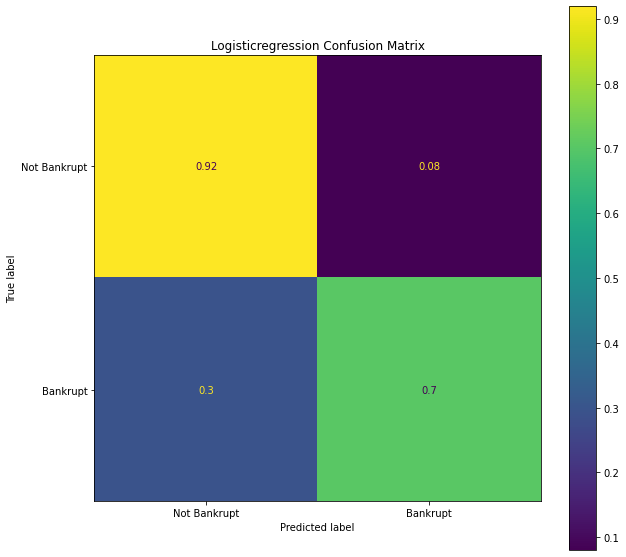

In [60]:
model_lr.fit(X_train_and_val, y_train_and_val)
Plot_Confusion_Matrix(model_lr, threshold_lr)

### Random Forest Classifier

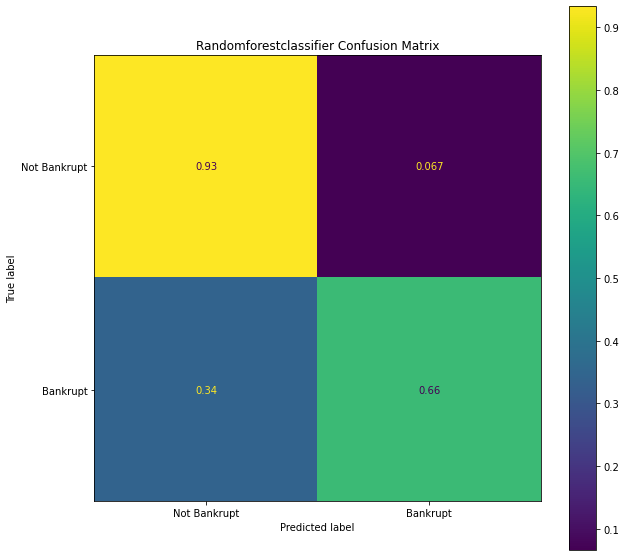

In [61]:
Plot_Confusion_Matrix(best_rf, threshold_rf)

### XG Boost Classifier

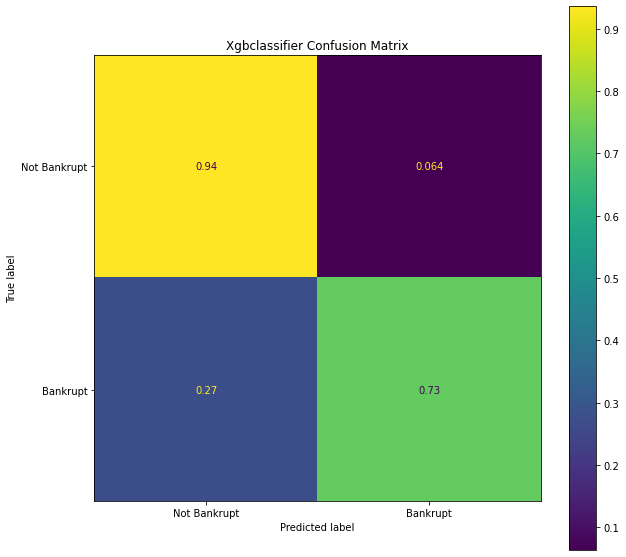

In [62]:
Plot_Confusion_Matrix(best_xgb, threshold_xgb)

## ROC Curves

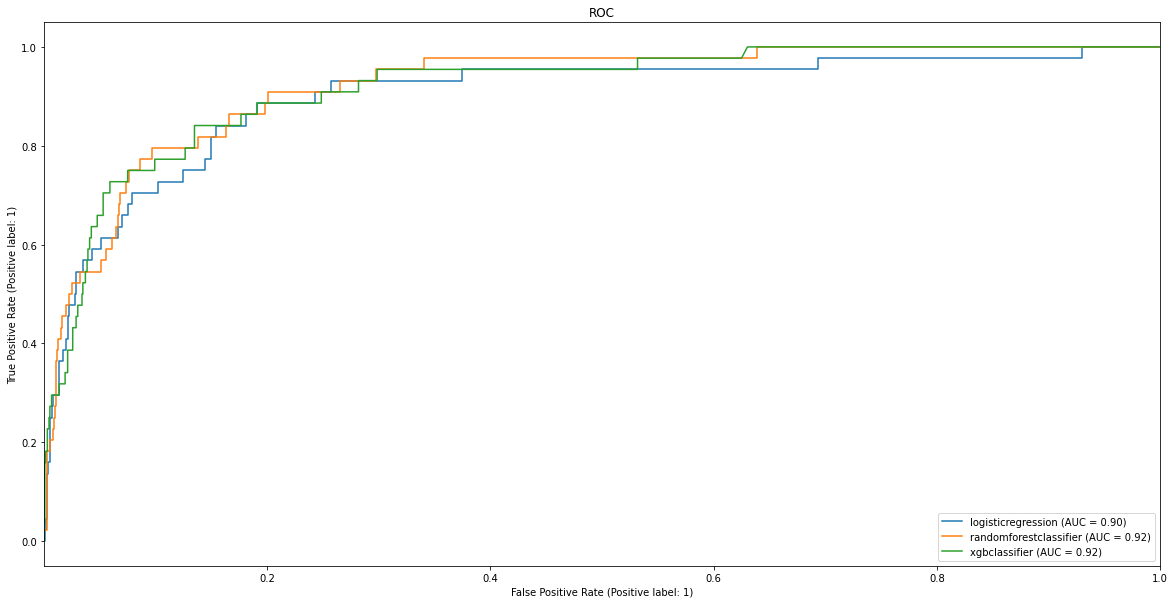

In [63]:
for i in range(len(models)):
    if i==0:
        fig, ax = Plot_ROC_Curve(models[i], thresholds[i])
    else:
        Plot_ROC_Curve(models[i], thresholds[i], fig, ax)

## Precision-Recall Curves

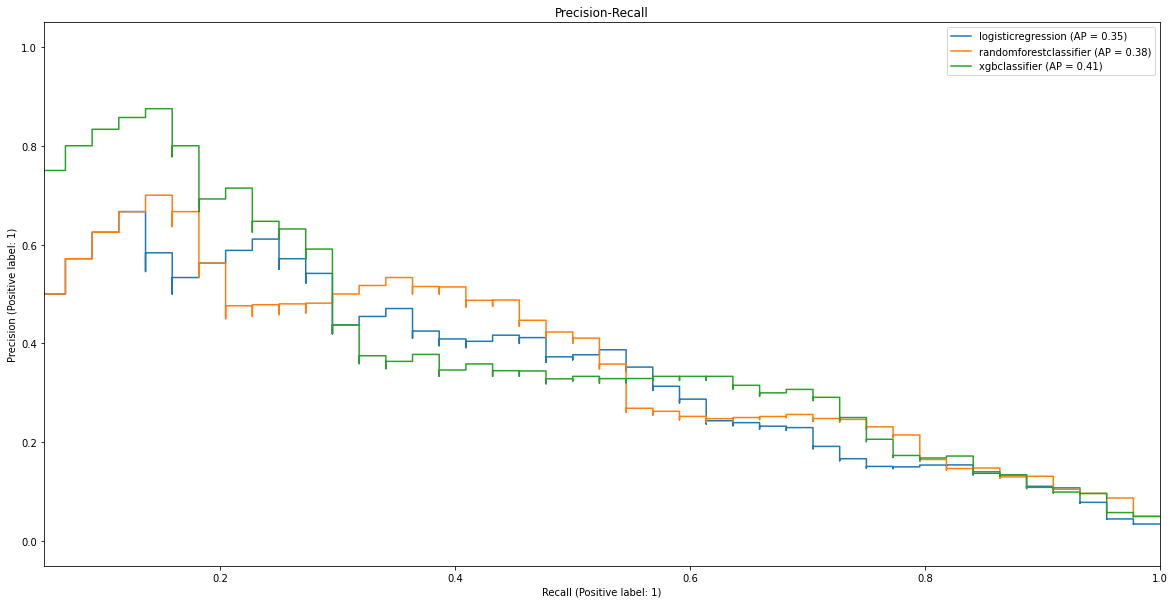

In [64]:
for i in range(len(models)):
    if i==0:
        fig, ax = Plot_PR_Curve(models[i], thresholds[i])
    else:
        Plot_PR_Curve(models[i], thresholds[i], fig, ax)
    ax.legend(loc="upper right")

# Permuted Feature Importances

In [65]:
from sklearn.inspection import permutation_importance
import seaborn as sns
sns.set(font_scale=3)

In [163]:
min_importance = 0.00001

In [66]:
def Permute_Features(model):
    mean_perm_imp = np.repeat(0.0, len(X_train_and_val.columns))
    for train_ind, val_ind in skf.split(X_train_and_val, y_train_and_val):
        
        #Train and Validation Splits
        X_train, y_train = X_train_and_val.iloc[train_ind], y_train_and_val.iloc[train_ind]
        X_val, y_val = X_train_and_val.iloc[val_ind], y_train_and_val.iloc[val_ind]
        
        #Fit to Training Split
        model.fit(X_train, y_train)
        
        #Find and Sort Importances
        perm_imp = permutation_importance(model, X_val, y_val, scoring=ap_scorer, n_repeats=20, n_jobs=-1)
        mean_perm_imp += perm_imp['importances_mean']
    
    mean_perm_imp /= skf.n_splits
    df_perm = pd.DataFrame(mean_perm_imp, index=X_val.columns, columns=['imp_mean']).sort_values(
        by='imp_mean', ascending=False)
        
    return df_perm

## Random Forest

In [118]:
perm_rf = Permute_Features(best_rf)
plt.subplots(figsize=(20,40))
sns.barplot(x=perm_rf['imp_mean'], y=perm_rf.index, orient='h');

## XG Boost

In [119]:
perm_xgb = Permute_Features(best_xgb)
plt.subplots(figsize=(20,40))
sns.barplot(x=perm_xgb['imp_mean'], y=perm_xgb.index, orient='h');

## Best and Worst Features

In [166]:
worst_cols = list( set(perm_rf[perm_rf['imp_mean']<=min_importance].index) 
                 & set(perm_xgb[perm_xgb['imp_mean']<=min_importance].index) )
if len(worst_cols) > 0:
    print("Drop These Columns in the Wrangle Function:")
    display(worst_cols)
else:
    print("No Unimportant Columns Dectected")
    
best_cols = list( set(perm_rf[perm_rf['imp_mean']>min_importance].index) 
                 & set(perm_xgb[perm_xgb['imp_mean']>min_importance].index) )
print("Most Important Columns:")
display(best_cols)

Drop These Columns in the Wrangle Function:


['Total assets to GNP price']

Most Important Columns:


['Total Asset Growth Rate',
 'Current Ratio',
 'Continuous interest rate (after tax)',
 'Equity to Long-term Liability',
 'Revenue per person',
 'Allocation rate per person',
 'Cash/Current Liability',
 'Research and development expense rate',
 'Quick Assets/Current Liability',
 'Operating Profit Per Share (Yuan ¥)',
 'Cash/Total Assets',
 'Long-term Liability to Current Assets',
 'Tax rate (A)',
 'Fixed Assets Turnover Frequency',
 'Net Worth Turnover Rate (times)',
 'Interest-bearing debt interest rate',
 'Average Collection Days',
 'Total income/Total expense',
 'Working Capital Turnover Rate',
 'Total expense/Assets',
 'Cash Turnover Rate',
 'Equity to Liability',
 'Current Liability to Liability',
 'Quick Ratio',
 'Current Asset Turnover Rate',
 'Net Value Growth Rate',
 'Net Value Per Share (C)',
 'Quick Asset Turnover Rate',
 'Degree of Financial Leverage (DFL)',
 'Revenue Per Share (Yuan ¥)',
 'Total debt/Total net worth',
 'Accounts Receivable Turnover']

## Model Disagreement

In [167]:
imp = perm_rf.copy()
imp.columns = ['rf']
imp['xgb'] = perm_xgb['imp_mean']
imp['diff'] = (abs(imp['xgb'] - imp['rf']))
imp = imp.sort_values(by='diff', ascending = False)
print("Columns Where Models Disagree:")
differing_cols = list( ( set(perm_rf.index) & set(worst_cols_xgb.index) ) 
        .union( set(perm_xgb.index) & set(worst_cols_rf.index) ) )
display(differing_cols)
display(imp.loc[differing_cols].sort_values(by='diff', ascending=False))

Columns Where Models Disagree:


['Realized Sales Gross Profit Growth Rate',
 'Interest Expense Ratio',
 'Fixed Assets to Assets',
 'Contingent liabilities/Net worth',
 'Inventory Turnover Rate (times)',
 'Current Liability to Current Assets',
 'Total assets to GNP price']

,rf,xgb,diff
Current Liability to Current Assets,0.014266,-0.000490,0.014755
Inventory Turnover Rate (times),0.009143,-0.001275,0.010418
Realized Sales Gross Profit Growth Rate,0.006469,-0.003312,0.009781
Fixed Assets to Assets,-0.002898,0.005278,0.008176
Interest Expense Ratio,0.007362,-0.000418,0.007779
Contingent liabilities/Net worth,0.003977,-0.000123,0.004100
Total assets to GNP price,-0.000011,-0.000424,0.000413


## Partial Dependence Plots

In [170]:
from sklearn.inspection import PartialDependenceDisplay
sns.set(font_scale=1)

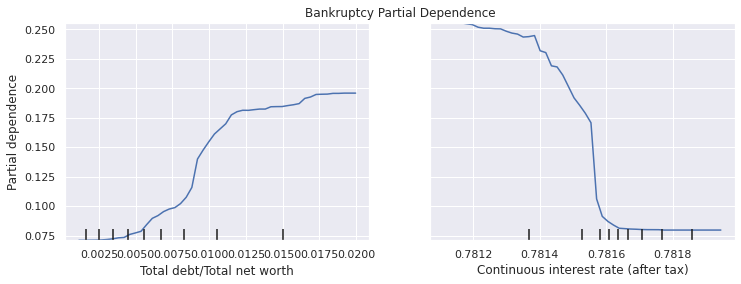

In [171]:
feature_1 = 'Total debt/Total net worth'
feature_2 = 'Continuous interest rate (after tax)'
model = best_rf
model_features = best_rf.feature_names_in_

fig, ax = plt.subplots(1,1, figsize=(12,4))
PartialDependenceDisplay.from_estimator(model,
                        feature_names=model_features, 
                        features=[feature_1, feature_2], 
                        X=X,
                        grid_resolution=50,
                        ax=ax);

ax.set_title('Bankruptcy Partial Dependence')

plt.show()

## Shapley Plots

In [177]:
import shap

In [178]:
row = X[ y == 1 ]['Total debt/Total net worth'].sort_values(ascending=True).index[0]
shap_ex = shap.TreeExplainer(model.named_steps[list(model.named_steps)[-1]])
shap_values = shap_ex.shap_values(X)
shap.initjs()
shap.force_plot(base_value = shap_ex.expected_value[1],
                shap_values = shap_values[1][row,:],
                features = X.iloc[row,:])

**The Shapley plot above shows that if we select a company with a low `Total Debt to Total Net Worth Ratio`, its predicted probability of bankruptcy will be under downward pressure. However, for the row chosen, this effect is canceled out by its `Continuous Compound Interest` and `Net Value Growth Rate` values.**